## Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from ridership_strava.config import  PROCESSED_DATA_DIR, RANDOM_STATE

%matplotlib inline


2025-10-15 21:03:19.771 | INFO     | ridership_strava.config:<module>:22 - PROJ_ROOT path is: /home/lliebsch/Escritorio/TFM
2025-10-15 21:03:19.771 | INFO     | ridership_strava.config:<module>:51 - Raw data path: /home/lliebsch/Escritorio/TFM/data/raw
2025-10-15 21:03:19.772 | INFO     | ridership_strava.config:<module>:52 - External data path: /home/lliebsch/Escritorio/TFM/data/external
2025-10-15 21:03:19.772 | INFO     | ridership_strava.config:<module>:53 - Interim data path: /home/lliebsch/Escritorio/TFM/data/interim
2025-10-15 21:03:19.772 | INFO     | ridership_strava.config:<module>:54 - Processed data path: /home/lliebsch/Escritorio/TFM/data/processed
2025-10-15 21:03:19.772 | INFO     | ridership_strava.config:<module>:55 - Models path: /home/lliebsch/Escritorio/TFM/models


In [2]:
SAVE_OUTPUT = True
INPUT_DATA = "segments_with_data"
OUTPUT_DATA = 'modelling_data'
EXCLUDE_END = ['BIKE_INFRA_TYPE1_Sharrows']


## Load data

In [3]:
# Read the first dataset
with (PROCESSED_DATA_DIR/f'{INPUT_DATA}.csv').open() as f:
    data = pd.read_csv(f, delimiter=',')

# Print the shape and check for duplicates
print(data.shape)
print("Duplicates: ", data.duplicated(["id", "AADBT"]).sum())
print(data.columns)
data.head()

(334, 104)
Duplicates:  0
Index(['NOM_TRAM', 'NOM_EIX', 'TYPE', 'ENLLAÇ', 'SURFACE', 'DIRECTION',
       'LOCATION', 'TYPOLOGY', 'SEPARATORS', 'YEAR_CONSTRUCTION',
       ...
       'min_dist_to_bus_mile', 'Number_of_secondary_education',
       'min_dist_to_secondary_education_mile', 'counter_id', 'street_id',
       'distance', 'Id_aforament', 'directionality', 'direction_counter',
       'AADBT'],
      dtype='object', length=104)


,NOM_TRAM,NOM_EIX,TYPE,ENLLAÇ,SURFACE,DIRECTION,LOCATION,TYPOLOGY,SEPARATORS,YEAR_CONSTRUCTION,...,min_dist_to_bus_mile,Number_of_secondary_education,min_dist_to_secondary_education_mile,counter_id,street_id,distance,Id_aforament,directionality,direction_counter,AADBT
0,C. Muntaner - Gran Via Corts Catalanes - C. Se...,Eix Aribau - Muntaner- Goya - St Antoni,CB Calçada Lateral,NO,Asphalt,Two-way,NaN,Bike lane,Yes,2009.0,...,0.048938,0.0,0.218469,20006,1,1.679921,20006,Bidirectional,NW,421
1,C. Consell de Cent - Pg de St. Joan - C. Marin...,C. Consell de Cent,CB Calçada Lateral,NO,Asphalt,One-way,NaN,Bike lane,Yes,1983.0,...,0.132060,1.0,0.042465,20009,4,2.986996,20009,Unidirectional,NE,1250
2,C. Aragó - C. del Clot - C. Escultors Claperò...,C. Aragó,CB Calçada Lateral,NO,Asphalt,One-way,NaN,Bike lane,Yes,2005.0,...,0.103147,1.0,0.153345,20026,16,0.553044,20026,Bidirectional,NE,1013
3,C. Marina - Pl. dels Voluntaris Olimípics - A...,C. Marina - Sud,CB Calçada Lateral,NO,Asphalt,Two-way,NaN,Bike lane,Yes,2005.0,...,0.022479,0.0,0.383034,20029,23,0.908912,20029,Bidirectional,NW,1358
4,C. Sardenya - C. Pujades - C. Llull,C. Sardenya,CB Calçada Lateral,NO,Asphalt,One-way,NaN,Bike lane,Yes,2017.0,...,0.004709,0.0,0.324501,20193,26,0.350297,20193,Unidirectional,SE,1027


In [4]:
data["AADBT"].describe()

count     334.000000
mean     1057.694611
std       802.700792
min        54.000000
25%       423.000000
50%       862.500000
75%      1383.000000
max      4430.000000
Name: AADBT, dtype: float64

In [5]:
data.columns

Index(['NOM_TRAM', 'NOM_EIX', 'TYPE', 'ENLLAÇ', 'SURFACE', 'DIRECTION',
       'LOCATION', 'TYPOLOGY', 'SEPARATORS', 'YEAR_CONSTRUCTION',
       ...
       'min_dist_to_bus_mile', 'Number_of_secondary_education',
       'min_dist_to_secondary_education_mile', 'counter_id', 'street_id',
       'distance', 'Id_aforament', 'directionality', 'direction_counter',
       'AADBT'],
      dtype='object', length=104)

## Data management

### Explore

In [6]:
data.shape

(334, 104)

In [7]:
# keep only the dependent and targetted independent variables
cols_to_drop = ['geometry','NOM_TRAM', 'NOM_EIX', 'TYPE','counter_id', 'street_id',
       'distance', 'Id_aforament', 'directionality', 'direction_counter',]
data1 = data.drop(columns=[col for col in cols_to_drop if col in data.columns])

data.shape[1] - data1.shape[1]

10

In [8]:
# prompt: Make a list with the objects in data, and a list for the int and float, exclude id and AADBT
#print(data.info(verbose=True), end='\n\n')
object_columns = data1.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data1.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude 'id' and 'AADBT' from the lists
if 'id' in numerical_columns:
  numerical_columns.remove('id')
if 'AADBT' in numerical_columns :
  numerical_columns.remove('AADBT')

print("Object columns:", object_columns, "Length:", len(object_columns))
print("Numerical columns:", numerical_columns)

Object columns: ['ENLLAÇ', 'SURFACE', 'DIRECTION', 'TYPOLOGY', 'SEPARATORS', 'AB_DIRECTION', 'BA_DIRECTION'] Length: 7
Numerical columns: ['LOCATION', 'YEAR_CONSTRUCTION', 'LENGTH', 'ANGLE', 'Port_Area_sqm', 'Distance_to_Port', 'Beach_Area_sqm', 'Distance_to_Beach', 'Forest_Area_sqm', 'Distance_to_Forest', 'Urban_Area_sqm', 'Distance_to_Urban', 'Commercial_Area_sqm', 'Distance_to_Commercial', 'Leisure_Area_sqm', 'Distance_to_Leisure', 'district', 'neighborhood', 'pct_male', 'pct_female', 'AgeGroup_0_19', 'AgeGroup_20_44', 'AgeGroup_45_64', 'AgeGroup_65_plus', 'avg_gross_income_per_household', 'total_trip_count', 'forward_trip_count', 'reverse_trip_count', 'commute_ratio', 'total_trip_count_V2', 'commute_ratio_V2', 'code_segment', 'total_flow', 'total_lanes', 'degree_imd', 'closeness_imd', 'betweenness_imd', 'eigenvector_imd', 'degree', 'closeness', 'betweenness', 'eigenvector', 'elevation', 'lat', 'lon', 'Number_of_universities', 'min_dist_to_universities_mile', 'Number_of_train', 'min

<Figure size 5000x5000 with 0 Axes>

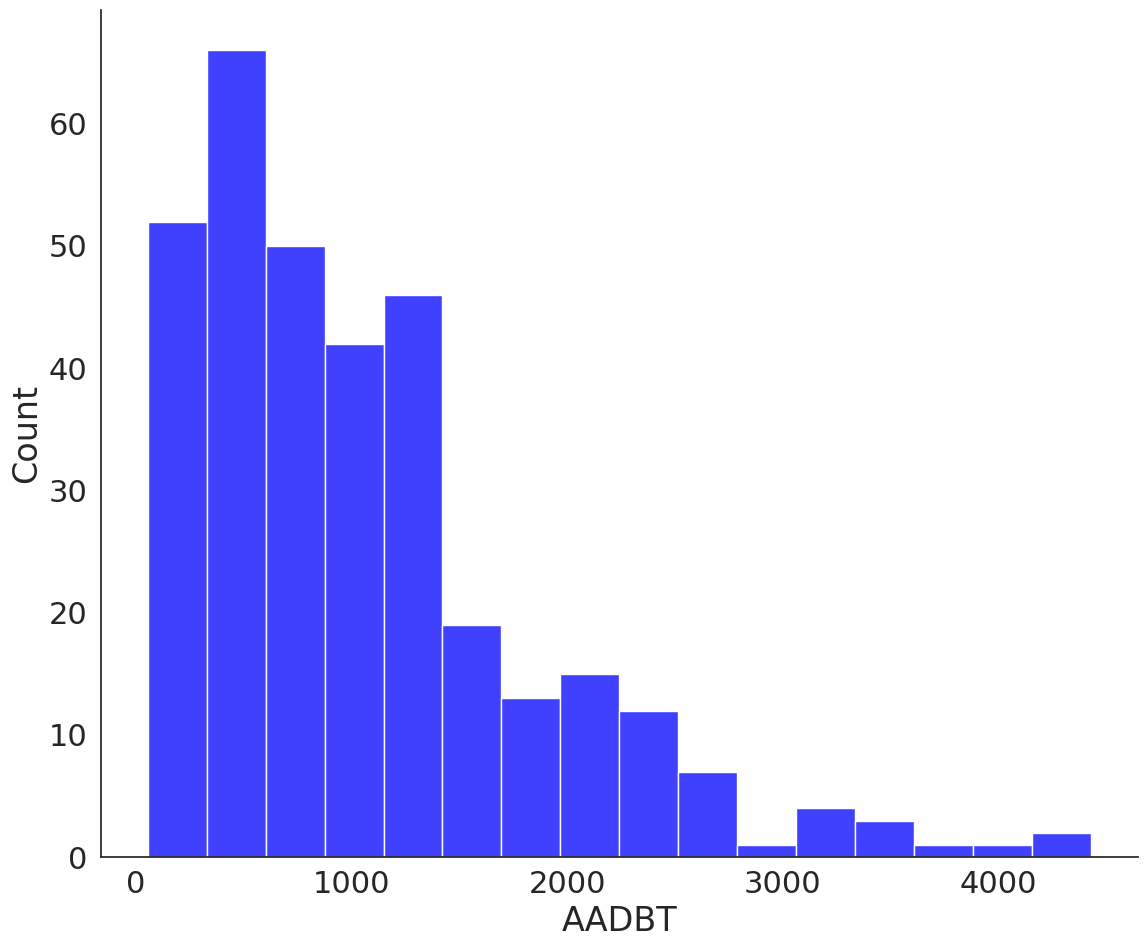

In [9]:
# Bar density plot for permanent counters AADBT
plt.figure(figsize=(50,50))
sns.set_theme(style='white',font_scale=2, palette='deep')
g=sns.displot(data1, x="AADBT", color='blue',height=10, aspect=1.2)
g.set(xlabel='AADBT')
plt.show()

### Get dummies

In [10]:
data1.shape

(334, 94)

In [11]:
data1=pd.get_dummies(data1, columns=object_columns)
print(data1.dtypes.value_counts())


float64    80
bool       27
int64       7
Name: count, dtype: int64


In [12]:
print(data1.shape)
print(data1.columns)

bool_columns = data1.select_dtypes(include='bool').columns.tolist()
print("Boolean columns:", bool_columns)

(334, 114)
Index(['LOCATION', 'YEAR_CONSTRUCTION', 'LENGTH', 'ANGLE', 'id',
       'Port_Area_sqm', 'Distance_to_Port', 'Beach_Area_sqm',
       'Distance_to_Beach', 'Forest_Area_sqm',
       ...
       'AB_DIRECTION_SW', 'AB_DIRECTION_W', 'BA_DIRECTION_E', 'BA_DIRECTION_N',
       'BA_DIRECTION_NE', 'BA_DIRECTION_NW', 'BA_DIRECTION_S',
       'BA_DIRECTION_SE', 'BA_DIRECTION_SW', 'BA_DIRECTION_W'],
      dtype='object', length=114)
Boolean columns: ['ENLLAÇ_NO', 'ENLLAÇ_SI', 'SURFACE_Asphalt', 'SURFACE_Concrete slab', 'DIRECTION_One-way', 'DIRECTION_Two-way', 'TYPOLOGY_Bike lane', 'TYPOLOGY_Bike lane on sidewalk', 'TYPOLOGY_Cyclable space on road', 'SEPARATORS_No', 'SEPARATORS_Yes', 'AB_DIRECTION_E', 'AB_DIRECTION_N', 'AB_DIRECTION_NE', 'AB_DIRECTION_NW', 'AB_DIRECTION_S', 'AB_DIRECTION_SE', 'AB_DIRECTION_SW', 'AB_DIRECTION_W', 'BA_DIRECTION_E', 'BA_DIRECTION_N', 'BA_DIRECTION_NE', 'BA_DIRECTION_NW', 'BA_DIRECTION_S', 'BA_DIRECTION_SE', 'BA_DIRECTION_SW', 'BA_DIRECTION_W']


### Transform variables

In [13]:
# # Transformations of Strava counts
# data1["strava_share"] = data1["total_trip_count"] / data1["total_trip_count"].sum()
# data1["strava_daily"] = data1["total_trip_count"] / 365
# data1["strava_log"] = np.log1p(data1["total_trip_count"])    # log(1+x)
# data1["strava_sqrt"] = np.sqrt(data1["total_trip_count"])   # sqrt(x)
# data1["strava_cbrt"] = np.cbrt(data1["total_trip_count"])   # cubic root
# data1["strava_rank"] = data1["total_trip_count"].rank()     # rank transform
# data1["strava_bin"] = pd.qcut(data1["total_trip_count"], q=5, labels=False) # quintiles


### lets check the correlation and filter the variables that maintain less than 0.15 correclation with dependent variable

In [14]:
data2=data1.drop(['id'],axis=1)
data2.shape

(334, 113)

In [15]:
# Calculate the correlation matrix
corr = data2.corr()

# Extract the correlations of ADBT with other variables
adbt_corr = corr['AADBT'].drop(['AADBT'])

# Sort the correlations in descending order
sorted_adbt_corr = adbt_corr.sort_values(ascending=False)

print(sorted_adbt_corr.tail(10))

min_dist_to_fgc_mile     -0.389475
min_dist_to_train_mile   -0.402858
district                 -0.407453
closeness_imd            -0.421738
LOCATION                       NaN
Beach_Area_sqm                 NaN
Forest_Area_sqm                NaN
eigenvector_imd                NaN
Number_of_signals              NaN
Number_of_bike_signals         NaN
Name: AADBT, dtype: float64


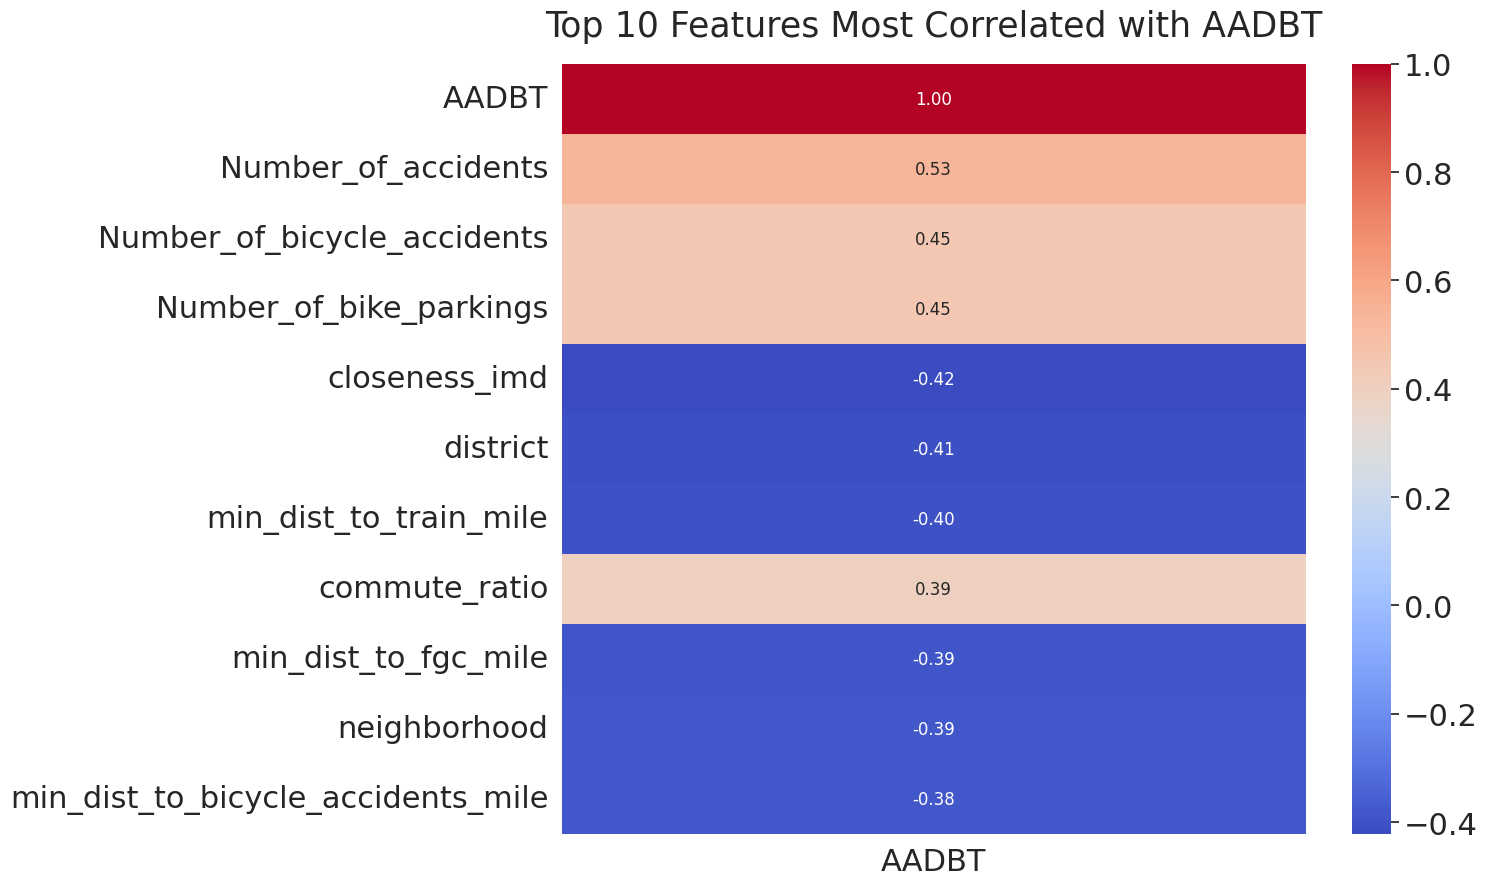

In [34]:
# Select the 10 most relevant features including the target 'AADBT' (only first column)
top_features = data2.corr()['AADBT'].abs().sort_values(ascending=False).index[:11]
plt.figure(figsize=(12, 10))
sns.heatmap(data2[top_features].corr()[[top_features[0]]], cmap="coolwarm", annot=True, fmt=".2f", annot_kws={"fontsize":12})
plt.title("Top 10 Features Most Correlated with AADBT", fontsize=25, pad=20)
plt.show()

In [16]:
corrMatrix1 = data2.corr()

NaN_corr_features = corrMatrix1.index[corrMatrix1["AADBT"].isna()]
print("NaN correlation features with AADBT:", len(NaN_corr_features))

low_corr_features = corrMatrix1.index[round(abs(corrMatrix1["AADBT"]),2)<=0.15]
print("Low correlation features with AADBT (|corr| <= 0.15):", len(low_corr_features))

top_corr_features = corrMatrix1.index[round(abs(corrMatrix1["AADBT"]),2)>0.15]
print("Top correlation features with ADBT (|corr| > 0.15):", len(top_corr_features)-1)#The -1 is the AADBT    
top_corr_features

NaN correlation features with AADBT: 6
Low correlation features with AADBT (|corr| <= 0.15): 52
Top correlation features with ADBT (|corr| > 0.15): 54


Index(['YEAR_CONSTRUCTION', 'ANGLE', 'Port_Area_sqm', 'Distance_to_Port',
       'Distance_to_Beach', 'Urban_Area_sqm', 'Distance_to_Urban',
       'Commercial_Area_sqm', 'Leisure_Area_sqm', 'Distance_to_Leisure',
       'district', 'neighborhood', 'forward_trip_count', 'commute_ratio',
       'total_flow', 'degree_imd', 'closeness_imd', 'degree', 'elevation',
       'lat', 'min_dist_to_universities_mile', 'min_dist_to_train_mile',
       'Number_of_bike_parkings', 'min_dist_to_bike_parkings_mile',
       'min_dist_to_signals_mile', 'Number_of_bus_nocturn', 'Number_of_metro',
       'min_dist_to_metro_mile', 'Number_of_job_training',
       'min_dist_to_job_training_mile', 'min_dist_to_kindergarten_mile',
       'min_dist_to_fgc_mile', 'Number_of_primary_education',
       'min_dist_to_primary_education_mile', 'min_dist_to_bike_signals_mile',
       'Number_of_transports', 'min_dist_to_transports_mile',
       'Number_of_bicing', 'Capacity_bicing', 'Number_of_accidents',
       'min_di

In [17]:
#Get variabloes that start with BIKE_INFRA_TYPE1 & BIKE_INFRA_TYPE2
bike_infra_type1 = [col for col in data2.columns if col.startswith('BIKE_INFRA_TYPE1')]
# bike_infra_type2 = [col for col in data2.columns if col.startswith('BIKE_INFRA_TYPE2')]


data3 = data2[list(top_corr_features) + bike_infra_type1]
list(data3.columns)

['YEAR_CONSTRUCTION',
 'ANGLE',
 'Port_Area_sqm',
 'Distance_to_Port',
 'Distance_to_Beach',
 'Urban_Area_sqm',
 'Distance_to_Urban',
 'Commercial_Area_sqm',
 'Leisure_Area_sqm',
 'Distance_to_Leisure',
 'district',
 'neighborhood',
 'forward_trip_count',
 'commute_ratio',
 'total_flow',
 'degree_imd',
 'closeness_imd',
 'degree',
 'elevation',
 'lat',
 'min_dist_to_universities_mile',
 'min_dist_to_train_mile',
 'Number_of_bike_parkings',
 'min_dist_to_bike_parkings_mile',
 'min_dist_to_signals_mile',
 'Number_of_bus_nocturn',
 'Number_of_metro',
 'min_dist_to_metro_mile',
 'Number_of_job_training',
 'min_dist_to_job_training_mile',
 'min_dist_to_kindergarten_mile',
 'min_dist_to_fgc_mile',
 'Number_of_primary_education',
 'min_dist_to_primary_education_mile',
 'min_dist_to_bike_signals_mile',
 'Number_of_transports',
 'min_dist_to_transports_mile',
 'Number_of_bicing',
 'Capacity_bicing',
 'Number_of_accidents',
 'min_dist_to_accidents_mile',
 'Number_of_bicycle_accidents',
 'min_dis

### Now drop the variables that have VIF greater than 5

In [18]:
# Drop specific columns
X_dataf = data3.drop(["AADBT"], axis=1)

# Drop boolean columns for VIF calculation
bool_cols = X_dataf.columns[X_dataf.dtypes == 'bool']
X_dataf = X_dataf.select_dtypes(exclude=['bool'])

# VIF calculation loop
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
import pandas as pd

# VIF calculation loop
# VIF calculation loop
while True:
    X = add_constant(X_dataf)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif_data = vif_data[1:]  # Exclude the constant

    if vif_data['VIF'].max() <= 5:
        break

    # Identify the feature with the highest VIF
    drop_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']

    if drop_feature == "elevation":
        # Identify the feature most correlated with elevation
        correlations = X_dataf.corr()["elevation"].drop("elevation").sort_values(ascending=False)
        most_correlated_feature = correlations.idxmax()
        print(f"'elevation' selected with VIF {vif_data['VIF'].max()}, dropping most correlated feature: {most_correlated_feature} (correlation: {correlations[most_correlated_feature]:.3f})")

        # Drop the most correlated feature instead of elevation
        X_dataf = X_dataf.drop(columns=[most_correlated_feature])
    elif drop_feature == "closeness_imd":
        # Identify the feature most correlated with elevation
        correlations = X_dataf.corr()["closeness_imd"].drop("closeness_imd").sort_values(ascending=False)
        most_correlated_feature = correlations.idxmax()
        print(f"'closeness_imd' selected with VIF {vif_data['VIF'].max()}, dropping most correlated feature: {most_correlated_feature} (correlation: {correlations[most_correlated_feature]:.3f})")

        # Drop the most correlated feature instead of elevation
        X_dataf = X_dataf.drop(columns=[most_correlated_feature])
    else:
      print(f"Dropping {drop_feature} with VIF {vif_data['VIF'].max()}")
      # Drop the feature with the highest VIF
      X_dataf = X_dataf.drop(columns=[drop_feature])



# Sort the final VIF values
vif_data = vif_data.sort_values('VIF')
vif_data

/home/lliebsch/Escritorio/TFM/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping Port_Area_sqm with VIF inf
Dropping min_dist_to_signals_mile with VIF 1801439850948198.5
Dropping min_dist_to_bike_signals_mile with VIF 85516.91625328743
Dropping Distance_to_Leisure with VIF 1039.926031488143
Dropping neighborhood with VIF 251.5489843163787
Dropping min_dist_to_fgc_mile with VIF 57.3008856101508
'elevation' selected with VIF 17.20701092060089, dropping most correlated feature: Distance_to_Beach (correlation: 0.845)
Dropping Number_of_transports with VIF 16.190122376445533
Dropping Number_of_bicing with VIF 11.470515111899525
Dropping min_dist_to_primary_education_mile with VIF 9.487123499533416
'closeness_imd' selected with VIF 5.93238365778431, dropping most correlated feature: Commercial_Area_sqm (correlation: 0.530)
'closeness_imd' selected with VIF 5.809445296928053, dropping most correlated feature: min_dist_to_train_mile (correlation: 0.528)


,feature,VIF
29,min_dist_to_accidents_mile,1.312213
18,min_dist_to_bike_parkings_mile,1.363886
11,degree_imd,1.373648
1,YEAR_CONSTRUCTION,1.399742
2,ANGLE,1.422992
27,Capacity_bicing,1.631430
8,forward_trip_count,1.699551
6,Leisure_Area_sqm,1.751864
13,degree,1.798363
9,commute_ratio,1.914539


In [19]:
print("Final features selected (VIF <= 5):", len(vif_data))
list(vif_data['feature'])

Final features selected (VIF <= 5): 34


['min_dist_to_accidents_mile',
 'min_dist_to_bike_parkings_mile',
 'degree_imd',
 'YEAR_CONSTRUCTION',
 'ANGLE',
 'Capacity_bicing',
 'forward_trip_count',
 'Leisure_Area_sqm',
 'degree',
 'commute_ratio',
 'total_flow',
 'Urban_Area_sqm',
 'Number_of_primary_education',
 'min_dist_to_bicycle_accidents_mile',
 'Distance_to_Port',
 'Distance_to_Urban',
 'Number_of_job_training',
 'min_dist_to_job_training_mile',
 'min_dist_to_universities_mile',
 'min_dist_to_transports_mile',
 'Number_of_metro',
 'Number_of_bicycle_accidents',
 'min_dist_to_kindergarten_mile',
 'Number_of_secondary_education',
 'elevation',
 'Number_of_bike_parkings',
 'min_dist_to_metro_mile',
 'Number_of_accidents',
 'min_dist_to_secondary_education_mile',
 'lat',
 'Number_of_bus_nocturn',
 'Number_of_bus',
 'district',
 'closeness_imd']

### Now select the Independent variables that have correlation less than or equal to 0.60 among them

In [20]:
columns = ["AADBT"] +list(vif_data['feature'])+list(bool_cols)
data4=data1[columns]
print(data4.columns)
print(data4.shape)
data4.head()

Index(['AADBT', 'min_dist_to_accidents_mile', 'min_dist_to_bike_parkings_mile',
       'degree_imd', 'YEAR_CONSTRUCTION', 'ANGLE', 'Capacity_bicing',
       'forward_trip_count', 'Leisure_Area_sqm', 'degree', 'commute_ratio',
       'total_flow', 'Urban_Area_sqm', 'Number_of_primary_education',
       'min_dist_to_bicycle_accidents_mile', 'Distance_to_Port',
       'Distance_to_Urban', 'Number_of_job_training',
       'min_dist_to_job_training_mile', 'min_dist_to_universities_mile',
       'min_dist_to_transports_mile', 'Number_of_metro',
       'Number_of_bicycle_accidents', 'min_dist_to_kindergarten_mile',
       'Number_of_secondary_education', 'elevation', 'Number_of_bike_parkings',
       'min_dist_to_metro_mile', 'Number_of_accidents',
       'min_dist_to_secondary_education_mile', 'lat', 'Number_of_bus_nocturn',
       'Number_of_bus', 'district', 'closeness_imd', 'DIRECTION_One-way',
       'DIRECTION_Two-way', 'TYPOLOGY_Bike lane',
       'TYPOLOGY_Bike lane on sidewalk', 'SEP

,AADBT,min_dist_to_accidents_mile,min_dist_to_bike_parkings_mile,degree_imd,YEAR_CONSTRUCTION,ANGLE,Capacity_bicing,forward_trip_count,Leisure_Area_sqm,degree,...,district,closeness_imd,DIRECTION_One-way,DIRECTION_Two-way,TYPOLOGY_Bike lane,TYPOLOGY_Bike lane on sidewalk,SEPARATORS_No,SEPARATORS_Yes,AB_DIRECTION_NE,BA_DIRECTION_SW
0,421,0.013357,0.042764,0.000302,2009.0,311.395887,77.0,420.0,0.0,0.000940,...,2,4717.393488,False,True,True,False,False,True,False,False
1,1250,0.020939,0.011696,0.000302,1983.0,233.610018,66.0,360.0,0.0,0.000627,...,2,4321.312260,True,False,True,False,False,True,True,True
2,1013,0.076995,0.043557,0.000227,2005.0,52.786867,92.0,7065.0,0.0,0.000627,...,10,4661.036480,True,False,True,False,False,True,True,True
3,1358,0.016693,0.011300,0.000302,2005.0,306.828586,54.0,8265.0,0.0,0.001254,...,10,4863.308770,False,True,True,False,False,True,False,False
4,1027,0.042689,0.013788,0.000302,2017.0,127.696100,120.0,2180.0,0.0,0.000627,...,10,5056.000920,True,False,True,False,False,True,False,False


In [21]:
# Calculate the correlation matrix
correlation_matrix = data4[list(vif_data['feature'])+list(bool_cols)].corr()

# Filter the correlation matrix to find pairs with correlation higher than 0.6
high_corr_pairs = correlation_matrix[(correlation_matrix > 0.6) & (correlation_matrix != 1.0) | (correlation_matrix < -0.6)].stack().reset_index()

high_corr_pairs.columns = ['Attribute1', 'Attribute2', 'Correlation']

high_corr_pairs.head(30)

,Attribute1,Attribute2,Correlation
0,degree,DIRECTION_One-way,-0.853658
1,degree,DIRECTION_Two-way,0.853658
2,Number_of_job_training,min_dist_to_job_training_mile,-0.666363
3,min_dist_to_job_training_mile,Number_of_job_training,-0.666363
4,min_dist_to_transports_mile,Number_of_metro,-0.635354
5,Number_of_metro,min_dist_to_transports_mile,-0.635354
6,Number_of_bicycle_accidents,Number_of_accidents,0.704033
7,Number_of_secondary_education,min_dist_to_secondary_education_mile,-0.714759
8,Number_of_accidents,Number_of_bicycle_accidents,0.704033
9,Number_of_accidents,district,-0.602642


In [22]:
# prompt: For the variables in high_corr_pairs, select the one that is more correlatd to AADBT, and the first one if they are equally correlated. Drop the others

def select_most_correlated(df, target_col, high_corr_pairs):
  """Selects the most correlated variable to the target from a list of pairs.

  Args:
      df: The DataFrame containing the variables.
      target_col: The name of the target variable.
      high_corr_pairs: A DataFrame of highly correlated pairs.

  Returns:
      A list of variables to keep, prioritizing the most correlated to the target.
  """
  vars_to_keep = []
  vars_to_drop = set()

  for _, row in high_corr_pairs.iterrows():
      attr1 = row['Attribute1']
      attr2 = row['Attribute2']

      if attr1 not in vars_to_drop and attr2 not in vars_to_drop:
          corr1 = df[target_col].corr(df[attr1])
          corr2 = df[target_col].corr(df[attr2])
          
          
          if abs(corr1) > abs(corr2):
              vars_to_keep.append(attr1)
              vars_to_drop.add(attr2)
          elif abs(corr2) > abs(corr1):
              vars_to_keep.append(attr2)
              vars_to_drop.add(attr1)
          else:
              vars_to_keep.append(attr1)
              vars_to_drop.add(attr2)

  return vars_to_drop, vars_to_keep


# Assuming 'data4' is your DataFrame and 'high_corr_pairs' is the DataFrame of pairs
vars_to_drop,vars_to_keep = select_most_correlated(data4, 'AADBT', high_corr_pairs)


# Create a new DataFrame with the selected variables
data5 = data4.drop(columns=vars_to_drop)

# Special case: If both AB_DIRECTION_NE and BA_DIRECTION_SW are in data5, drop BA_DIRECTION_SW to avoid redundancy
if 'BA_DIRECTION_SW' in data5.columns and 'AB_DIRECTION_NE' in data5.columns:
    data5 = data5.drop(columns=['BA_DIRECTION_SW'])



print(data5.columns)
data5.shape

Index(['AADBT', 'min_dist_to_accidents_mile', 'min_dist_to_bike_parkings_mile',
       'degree_imd', 'YEAR_CONSTRUCTION', 'ANGLE', 'Capacity_bicing',
       'forward_trip_count', 'Leisure_Area_sqm', 'commute_ratio', 'total_flow',
       'Urban_Area_sqm', 'Number_of_primary_education',
       'min_dist_to_bicycle_accidents_mile', 'Distance_to_Port',
       'Distance_to_Urban', 'Number_of_job_training',
       'min_dist_to_universities_mile', 'Number_of_metro',
       'min_dist_to_kindergarten_mile', 'Number_of_secondary_education',
       'elevation', 'Number_of_bike_parkings', 'min_dist_to_metro_mile',
       'Number_of_accidents', 'lat', 'Number_of_bus_nocturn', 'closeness_imd',
       'DIRECTION_One-way', 'TYPOLOGY_Bike lane', 'SEPARATORS_Yes',
       'AB_DIRECTION_NE'],
      dtype='object')


(334, 32)

In [23]:
vars_to_keep

['DIRECTION_One-way',
 'Number_of_job_training',
 'Number_of_metro',
 'Number_of_accidents',
 'Number_of_secondary_education',
 'Number_of_accidents',
 'Number_of_bus_nocturn',
 'DIRECTION_One-way',
 'TYPOLOGY_Bike lane',
 'SEPARATORS_Yes']

In [24]:
#get correplation between ADBT and other variables
corr = data5.corr()
corr['AADBT'].sort_values(ascending=False)


AADBT                                 1.000000
Number_of_accidents                   0.534592
Number_of_bike_parkings               0.451545
commute_ratio                         0.394883
Number_of_metro                       0.336459
total_flow                            0.322890
DIRECTION_One-way                     0.318367
Number_of_job_training                0.303732
Distance_to_Port                      0.265410
Number_of_bus_nocturn                 0.242589
Number_of_secondary_education         0.219543
AB_DIRECTION_NE                       0.216286
forward_trip_count                    0.204811
Distance_to_Urban                     0.204107
Capacity_bicing                       0.180465
degree_imd                            0.177750
Number_of_primary_education           0.163758
SEPARATORS_Yes                       -0.158736
min_dist_to_kindergarten_mile        -0.158764
ANGLE                                -0.177780
Leisure_Area_sqm                     -0.177927
min_dist_to_b

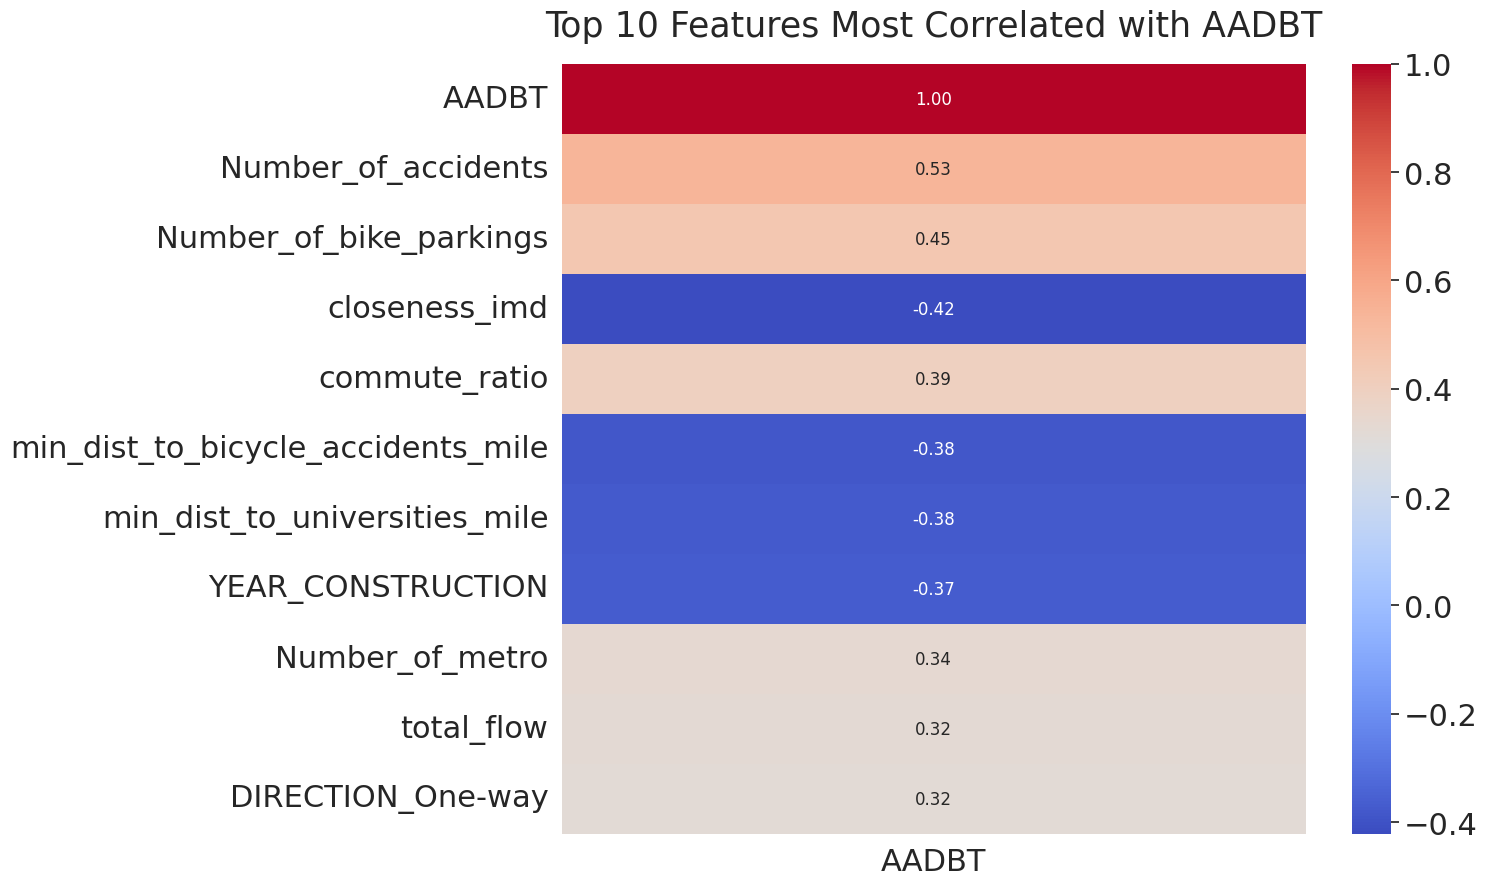

In [33]:
# Select the 10 most relevant features including the target 'AADBT' (only first column)
top_features = data5.corr()['AADBT'].abs().sort_values(ascending=False).index[:11]
plt.figure(figsize=(12, 10))
sns.heatmap(data5[top_features].corr()[[top_features[0]]], cmap="coolwarm", annot=True, fmt=".2f", annot_kws={"fontsize":12})
plt.title("Top 10 Features Most Correlated with AADBT", fontsize=25, pad=20)
plt.show()

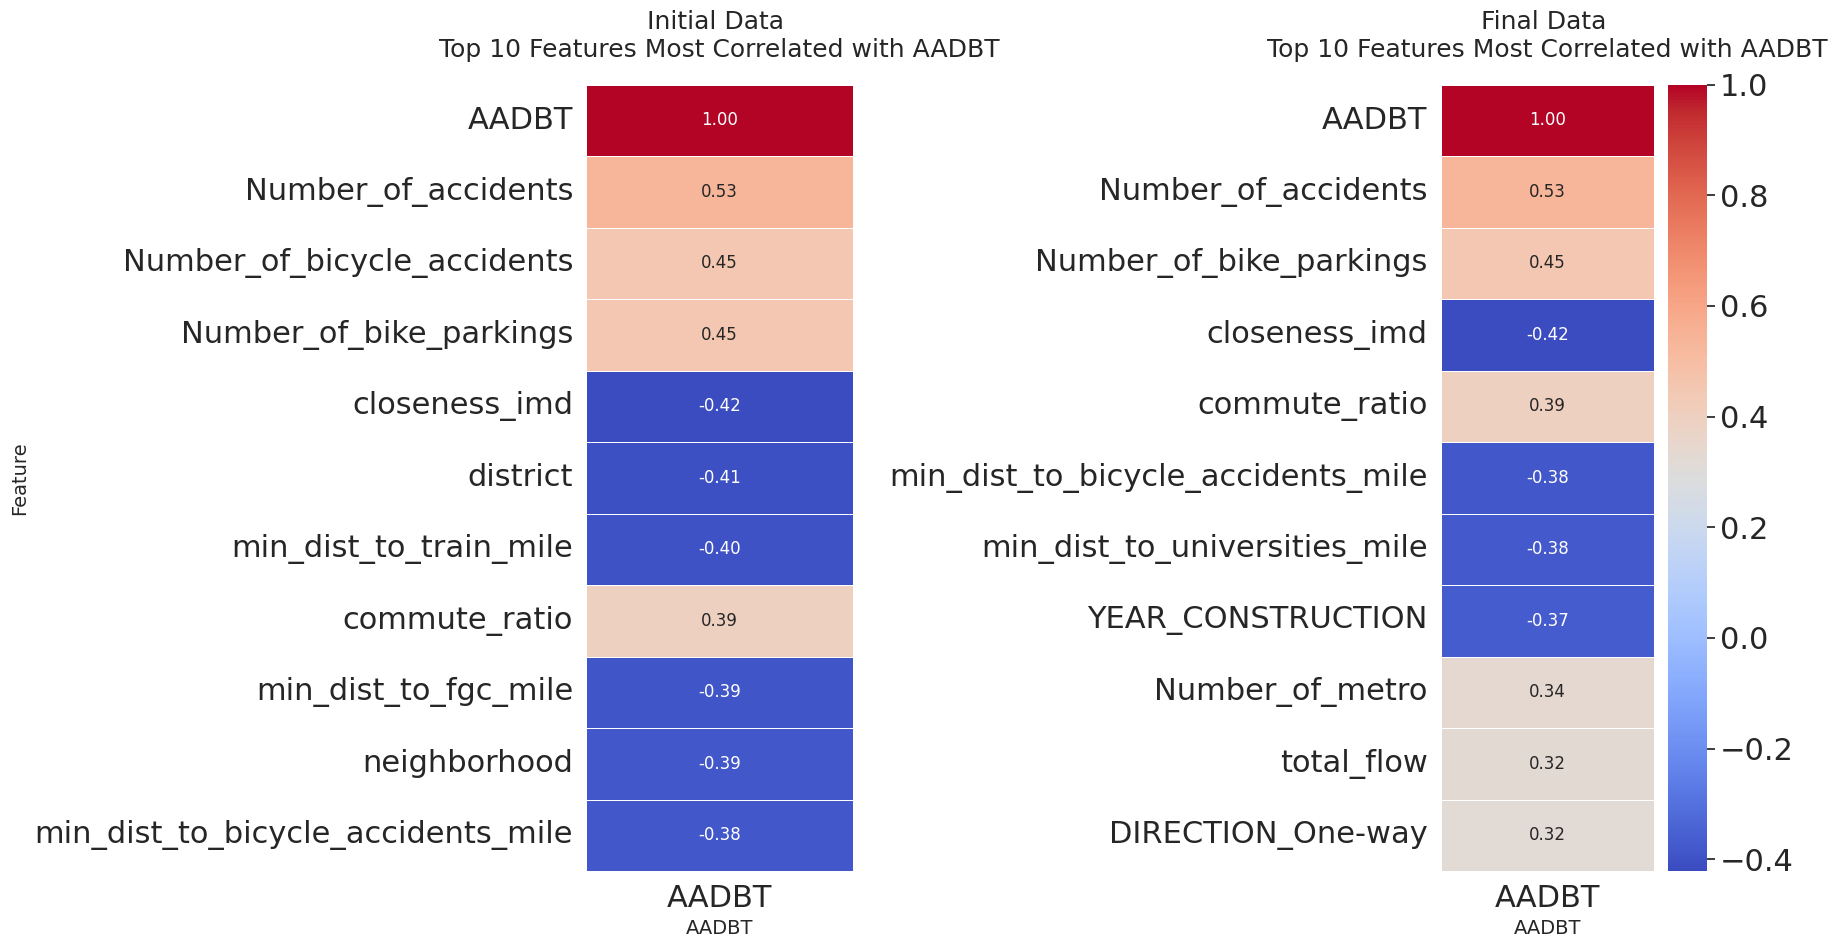

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate top correlated features for both datasets
top_features2 = data2.corr()['AADBT'].abs().sort_values(ascending=False).index[:11]
top_features5 = data5.corr()['AADBT'].abs().sort_values(ascending=False).index[:11]

# Compute correlation matrices
corr2 = data2[top_features2].corr()[[top_features2[0]]]
corr5 = data5[top_features5].corr()[[top_features5[0]]]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot initial data (data2)
sns.heatmap(
    corr2, cmap="coolwarm", annot=True, fmt=".2f",
    annot_kws={"fontsize": 12}, ax=axes[0], cbar=False, linewidths=0.5
)
axes[0].set_title("Initial Data \nTop 10 Features Most Correlated with AADBT", fontsize=18, pad=20)
axes[0].set_xlabel("AADBT", fontsize=14)
axes[0].set_ylabel("Feature", fontsize=14)

# Plot final data (data5)
sns.heatmap(
    corr5, cmap="coolwarm", annot=True, fmt=".2f",
    annot_kws={"fontsize": 12}, ax=axes[1], cbar=True, linewidths=0.5
)
axes[1].set_title("Final Data \nTop 10 Features Most Correlated with AADBT", fontsize=18, pad=20)
axes[1].set_xlabel("AADBT", fontsize=14)
axes[1].set_ylabel("")

# Improve layout
plt.tight_layout()
plt.show()


In [110]:
attributes = ['id'] + list(data5.columns)
# attributes.remove("BA_DIRECTION_SW")
modelling_data = data1[attributes].copy()

modelling_data.columns = [col.replace(' ', '_') for col in modelling_data.columns]
modelling_data.columns = [col.replace('-', '_') for col in modelling_data.columns]

modelling_data.columns


Index(['id', 'AADBT', 'min_dist_to_accidents_mile',
       'min_dist_to_bike_parkings_mile', 'degree_imd', 'YEAR_CONSTRUCTION',
       'ANGLE', 'Capacity_bicing', 'forward_trip_count', 'Leisure_Area_sqm',
       'commute_ratio', 'total_flow', 'Urban_Area_sqm',
       'Number_of_primary_education', 'min_dist_to_bicycle_accidents_mile',
       'Distance_to_Port', 'Distance_to_Urban', 'Number_of_job_training',
       'min_dist_to_universities_mile', 'Number_of_metro',
       'min_dist_to_kindergarten_mile', 'Number_of_secondary_education',
       'elevation', 'Number_of_bike_parkings', 'min_dist_to_metro_mile',
       'Number_of_accidents', 'lat', 'Number_of_bus_nocturn', 'closeness_imd',
       'DIRECTION_One_way', 'TYPOLOGY_Bike_lane', 'SEPARATORS_Yes',
       'AB_DIRECTION_NE'],
      dtype='object')

In [111]:
explore = modelling_data.drop(['id','AADBT'], axis=1)
desc = explore.agg(['mean', 'std', 'max', 'min']).T

desc['corr_with_AADBT'] = explore.apply(lambda x: modelling_data['AADBT'].corr(x))

# Round only numeric columns
for col in ['mean', 'std', 'max', 'min', 'corr_with_AADBT']:
    if col in desc.columns:
        desc[col] = pd.to_numeric(desc[col], errors='ignore').round(2)

desc = desc.sort_values("corr_with_AADBT", ascending=False)
desc.to_csv("explore_stats_corr_with_AADBT.csv")
desc

/tmp/ipykernel_99137/2136954992.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  desc[col] = pd.to_numeric(desc[col], errors='ignore').round(2)


,mean,std,max,min,corr_with_AADBT
Number_of_accidents,75.18,45.45,199.00,4.00,0.53
Number_of_bike_parkings,23.23,10.62,53.00,1.00,0.45
commute_ratio,0.27,0.12,0.55,0.00,0.39
Number_of_metro,1.37,1.94,9.00,0.00,0.34
DIRECTION_One_way,0.37,0.48,1.00,0.00,0.32
total_flow,10819.26,10999.55,55567.95,0.06,0.32
Number_of_job_training,0.43,0.67,3.00,0.00,0.30
Distance_to_Port,0.29,0.18,0.86,0.00,0.27
Number_of_bus_nocturn,3.27,1.80,8.00,0.00,0.24
Number_of_secondary_education,0.70,0.86,4.00,0.00,0.22


In [112]:
#Exclude the end columns
for col in EXCLUDE_END:
    if col in modelling_data.columns:
        modelling_data = modelling_data.drop(columns=[col])
        print(f"Dropping column: {col}")

## Changes 

In [113]:
print("After dropping due to correlation:",data3.shape[1]-1 )
print("After dropping due to VIF:",data4.shape[1]-1 )
print("After due to high correlation:",data5.shape[1]-1 )

After dropping due to correlation: 54
After dropping due to VIF: 42
After due to high correlation: 31


## Save output

In [114]:
if SAVE_OUTPUT:
  PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
  with (PROCESSED_DATA_DIR / f'{OUTPUT_DATA}.csv').open('w') as f:
    modelling_data.to_csv(f, index=False)
    



## Watermark

In [115]:
!python -m pip install watermark --quiet

/home/lliebsch/Escritorio/TFM/.venv/bin/python: No module named pip


In [116]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [117]:
%watermark

Last updated: 2025-09-14T09:52:11.556396+02:00

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.4.0

Compiler    : Clang 20.1.0 
OS          : Linux
Release     : 6.8.0-65-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 14
Architecture: 64bit



In [118]:
%watermark --iversions

statsmodels: 0.14.4
pandas     : 2.3.0
numpy      : 2.2.6
sklearn    : 1.7.0
matplotlib : 3.10.3
seaborn    : 0.13.2



In [119]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.5 LTS
Release:	22.04
Codename:	jammy
